This is my analysis of the Ames Housing prices data set. The goal is to predict house prices with the smalles root mean square of the log error possible. My final results were an error of 0.12130 and placement in the top 28% of the Kaggle leaderboard.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

In [2]:
#del training_data
training_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

Reset ID column as Index

In [3]:
training_data.set_index('Id',inplace=True)
test_data.set_index('Id',inplace=True)

In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

The first thing you will notice is that the data is composed of both numerical and categorical features. In order to perform linear regression on the categorical data, we will need to convert it to binary features using one hot encoding. 

Before we get to that, we must clean and process the data.

# Some Preliminary data exploration:

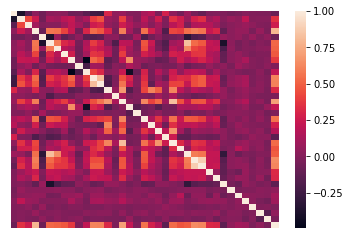

In [5]:
sns.heatmap(training_data.corr(),xticklabels=False,yticklabels=False)

A heatmap of correlations between numerical featuers. This suggests a lot of cross correlation in the features, which hints at using an algorith that can deal with cross correlation such as Lasso Regression.
Next we take a quick look at the top features correlated with Sale Price.

In [6]:
training_data.corr(method='spearman')['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.809829
GrLivArea        0.731310
GarageCars       0.690711
YearBuilt        0.652682
GarageArea       0.649379
FullBath         0.635957
TotalBsmtSF      0.602725
GarageYrBlt      0.593788
1stFlrSF         0.575408
YearRemodAdd     0.571159
TotRmsAbvGrd     0.532586
Fireplaces       0.519247
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.421309
LotFrontage      0.409076
WoodDeckSF       0.353802
HalfBath         0.343008
BsmtFinSF1       0.301871
2ndFlrSF         0.293598
BedroomAbvGr     0.234907
BsmtFullBath     0.225125
BsmtUnfSF        0.185197
ScreenPorch      0.100070
MoSold           0.069432
3SsnPorch        0.065440
PoolArea         0.058453
MSSubClass       0.007192
BsmtHalfBath    -0.012189
YrSold          -0.029899
BsmtFinSF2      -0.038806
MiscVal         -0.062727
LowQualFinSF    -0.067719
OverallCond     -0.129325
KitchenAbvGr    -0.164826
EnclosedPorch   -0.218394
Name: SalePrice, dtype: float64

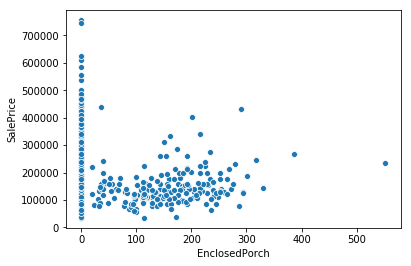

In [7]:
sns.scatterplot(x='EnclosedPorch',y='SalePrice',data=training_data)

Looking at the cross-correlations between the top variables correlated with Sale Price:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


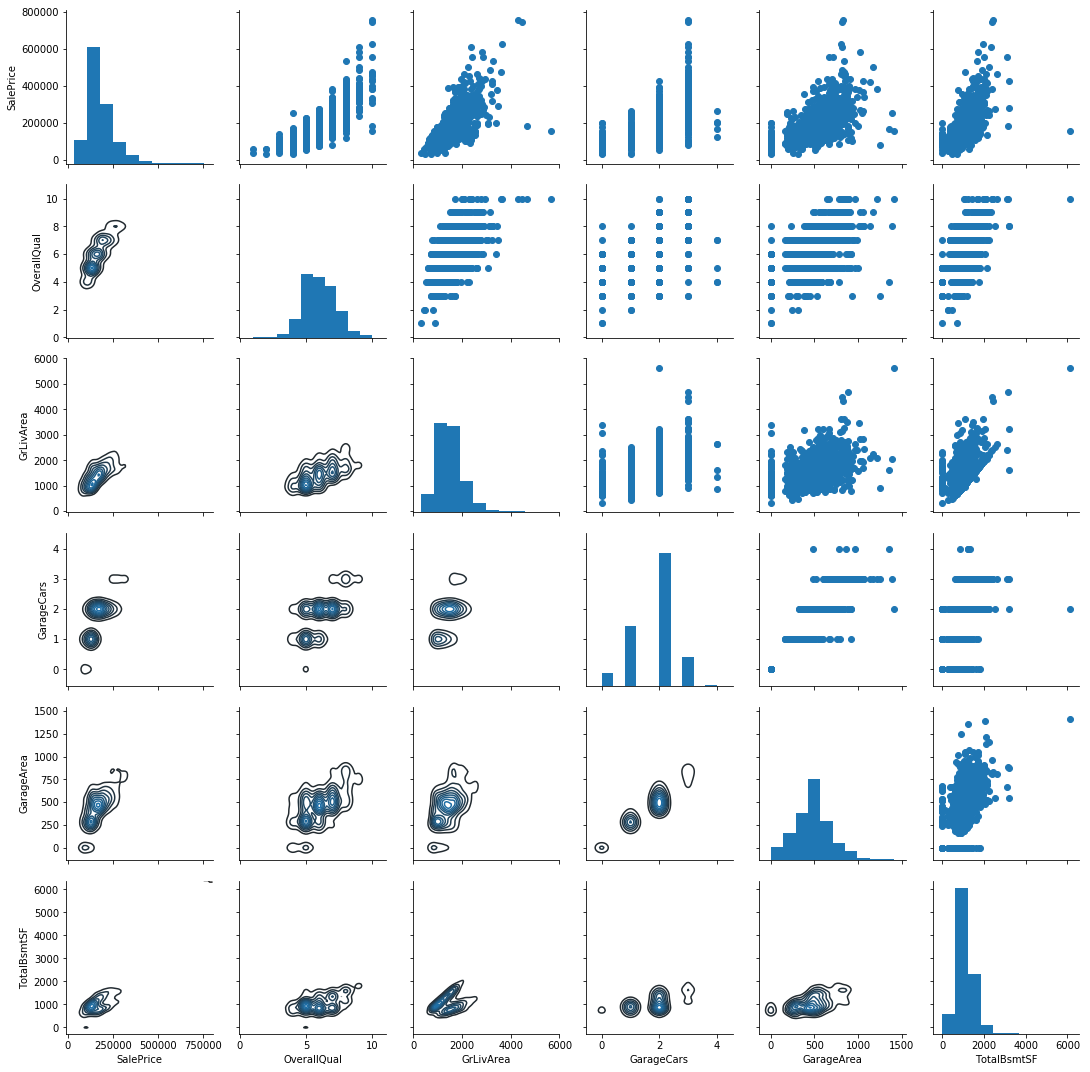

In [8]:
g=sns.PairGrid(data=training_data,vars=training_data.corr()['SalePrice'].sort_values(ascending=False).nlargest(6).index)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

There does seem to be a lot of cross correlation. I will eventually go back and do some feature engineering

# Filling Null Values

The data description usually tells us what the null values should be filled as.

In [9]:
training_data['Alley'].fillna(value='NoAlley',inplace=True)
training_data['LotFrontage'].fillna(value=0,inplace=True)
training_data['GarageType'].fillna(value='NoGarage',inplace=True)
training_data['Fence'].fillna(value='NoFence',inplace=True)
training_data['MasVnrType'].fillna(value='None',inplace=True)
training_data['MasVnrArea'].fillna(value=0,inplace=True)
training_data['BsmtQual'].fillna('No',inplace=True)
training_data['BsmtCond'].fillna('No',inplace=True)
training_data['BsmtExposure'].fillna('No',inplace=True)
training_data['BsmtFinType1'].fillna('No',inplace=True)
training_data['BsmtFinType2'].fillna('No',inplace=True)
training_data['FireplaceQu'].fillna('No',inplace=True)
training_data['GarageFinish'].fillna('No',inplace=True)
training_data['GarageQual'].fillna('No',inplace=True)
training_data['GarageCond'].fillna('No',inplace=True)
training_data['PoolQC'].fillna('No',inplace=True)
training_data['MiscFeature'].fillna('No',inplace=True)
training_data['GarageYrBlt'].fillna(training_data['YearBuilt'],inplace=True)
#training_data['Electrical'].fillna('SBrkr',inplace=True)

Do the same for test data, but with a few more features containing nulls.

In [10]:
test_data['Alley'].fillna(value='NoAlley',inplace=True)
test_data['LotFrontage'].fillna(value=0,inplace=True)
test_data['GarageType'].fillna(value='NoGarage',inplace=True)
test_data['Fence'].fillna(value='NoFence',inplace=True)
test_data['MasVnrType'].fillna(value='None',inplace=True)
test_data['MasVnrArea'].fillna(value=0,inplace=True)
test_data['BsmtQual'].fillna('No',inplace=True)
test_data['BsmtCond'].fillna('No',inplace=True)
test_data['BsmtExposure'].fillna('No',inplace=True)
test_data['BsmtFinType1'].fillna('No',inplace=True)
test_data['BsmtFinType2'].fillna('No',inplace=True)
test_data['FireplaceQu'].fillna('No',inplace=True)
test_data['GarageFinish'].fillna('No',inplace=True)
test_data['GarageQual'].fillna('No',inplace=True)
test_data['GarageCond'].fillna('No',inplace=True)
test_data['PoolQC'].fillna('No',inplace=True)
test_data['MiscFeature'].fillna('No',inplace=True)
test_data['GarageYrBlt'].fillna(test_data['YearBuilt'],inplace=True)

test_data['Utilities'].fillna('AllPub',inplace=True)
test_data['BsmtFinSF1'].fillna(0,inplace=True)
test_data['BsmtFinSF2'].fillna(0,inplace=True)
test_data['BsmtUnfSF'].fillna(0,inplace=True)
test_data['TotalBsmtSF'].fillna(0,inplace=True)
test_data['BsmtFullBath'].fillna(0,inplace=True)
test_data['BsmtHalfBath'].fillna(0,inplace=True)
test_data['Functional'].fillna(8,inplace=True)
test_data['KitchenQual'].fillna(3,inplace=True)
test_data['SaleType'].fillna('WD',inplace=True)
test_data['GarageCars'].fillna(0,inplace=True)
test_data['Exterior1st'].fillna('VinylSd',inplace=True)
test_data['Exterior2nd'].fillna('VinylSd',inplace=True)
test_data['GarageArea'].fillna(0,inplace=True)
test_data['MSZoning'].fillna('RL',inplace=True)

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
MSSubClass       1459 non-null int64
MSZoning         1459 non-null object
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            1459 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1459 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1459 non-null object
Exterior2nd      1459

The Ames dataset description says that a few outliers with very large GrLivArea have strange behavior and suggests culling them, so that is what we will do.

In [12]:
training_data[(training_data['GrLivArea']>4000) & (training_data['SalePrice']<200000)]
training_data.drop(index=[523,1298],inplace=True)
training_data.dropna(subset=['Electrical'],inplace=True)

In [13]:
training_data.isnull().sum().sum()

0

In [14]:
test_data.isnull().sum().sum()

0

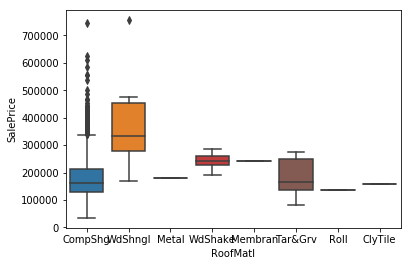

In [15]:
sns.boxplot(x='RoofMatl',y='SalePrice',data=training_data)

In [16]:
sum(training_data['RoofMatl']=='Membran')

1

# Data type conversions

Taking a look at one of the categorical features, "Functional". In the data description, this is defined as home functionality, with a wide range of values of broke-downedness.

Typ  Typical Functionality

   Min1 Minor Deductions 1
   
   Min2 Minor Deductions 2
   
   Mod  Moderate Deductions
   
   Maj1 Major Deductions 1
   
   Maj2 Major Deductions 2
   
   Sev  Severely Damaged
   
   Sal  Salvage only
   
   
   These seem to exist on a scale from Perfect Condition to an absolute disaster that is only good for the raw materials that can be salvaged from it. 

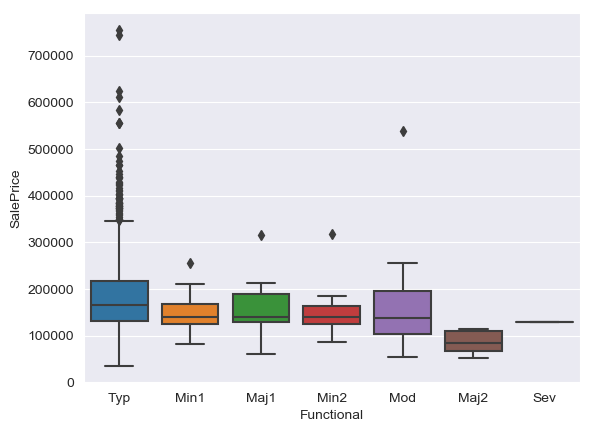

In [17]:
plt.style.use('default')
sns.set_style('darkgrid')
sns.boxplot(x='Functional',y='SalePrice',data=training_data)

Instead of letting it multiply into 7 different binary features, we can convert this to a numerical scale.

In [18]:
training_data['Functional'].replace({'Sal':0,'Sev':1,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8},inplace=True)

Upon inspection, the same is true for many of the other categorical features. Many of them can be converted with the same dictionary.

In [19]:
ExQuD={'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
training_data['ExterQual'].replace(ExQuD,inplace=True)
training_data['ExterCond'].replace(ExQuD,inplace=True)
training_data['BsmtQual'].replace(ExQuD,inplace=True)
training_data['BsmtCond'].replace(ExQuD,inplace=True)
training_data['BsmtExposure'].replace({'No':0,'Mn':1,'Av':2,'Gd':3},inplace=True)
training_data['HeatingQC'].replace(ExQuD,inplace=True)
training_data['CentralAir'].replace({'Y':1,'N':0},inplace=True)
training_data['KitchenQual'].replace(ExQuD,inplace=True)
training_data['GarageFinish'].replace({'No':0,'Unf':1,'RFn':2,'Fin':3},inplace=True)
training_data['GarageQual'].replace(ExQuD,inplace=True)
training_data['GarageCond'].replace(ExQuD,inplace=True)
training_data['PavedDrive'].replace({'N':0,'P':1,'Y':2},inplace=True)
training_data['PoolQC'].replace(ExQuD,inplace=True)
training_data['Fence'].replace({'NoFence':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4},inplace=True)
training_data['FireplaceQu'].replace(ExQuD,inplace=True)

test_data['ExterQual'].replace(ExQuD,inplace=True)
test_data['ExterCond'].replace(ExQuD,inplace=True)
test_data['BsmtQual'].replace(ExQuD,inplace=True)
test_data['BsmtCond'].replace(ExQuD,inplace=True)
test_data['BsmtExposure'].replace({'No':0,'Mn':1,'Av':2,'Gd':3},inplace=True)
test_data['HeatingQC'].replace(ExQuD,inplace=True)
test_data['CentralAir'].replace({'Y':1,'N':0},inplace=True)
test_data['KitchenQual'].replace(ExQuD,inplace=True)
test_data['Functional'].replace({'Sal':0,'Sev':1,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8},inplace=True)
test_data['FireplaceQu'].replace(ExQuD,inplace=True)
test_data['GarageFinish'].replace({'No':0,'Unf':1,'RFn':2,'Fin':3},inplace=True)
test_data['GarageQual'].replace(ExQuD,inplace=True)
test_data['GarageCond'].replace(ExQuD,inplace=True)
test_data['PavedDrive'].replace({'N':0,'P':1,'Y':2},inplace=True)
test_data['PoolQC'].replace(ExQuD,inplace=True)
test_data['Fence'].replace({'NoFence':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4},inplace=True)

In [20]:
#training_data['BsmtFinType1'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)
#training_data['BsmtFinType2'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)
#test_data['BsmtFinType1'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)
#test_data['BsmtFinType2'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)

Conversely, the feature MSSubClass is encoded as a number, but actually describes completely separate categories of house type. We wil convert this numerical feature into a categorical one.

In [21]:

training_data['MSSubClass'].replace({20 : "1-STORY 1946 & NEWER ALL STYLES", 30 : "1-STORY 1945 & OLDER", 
                                     40 : "1-STORY W/FINISHED ATTIC ALL AGES", 45 : "1-1/2 STORY - UNFINISHED ALL AGES", 
                                     50 : "1-1/2 STORY FINISHED ALL AGES", 60 : "2-STORY 1946 & NEWER",
                                     70 : "2-STORY 1945 & OLDER", 75 : "2-1/2 STORY ALL AGES", 
                                     80 : "SPLIT OR MULTI-LEVEL", 85 : "SPLIT FOYER",
                                     90 : "DUPLEX - ALL STYLES AND AGES", 
                                     120 : "1-STORY PUD (Planned Unit Development) - 1946 & NEWER", 
                                     150 : "1-1/2 STORY PUD - ALL AGES", 
                                     160 : "2-STORY PUD - 1946 & NEWER",
                                     180 : "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER", 
                                     190 : "2 FAMILY CONVERSION - ALL STYLES AND AGES"},inplace=True)

test_data['MSSubClass'].replace({20 : "1-STORY 1946 & NEWER ALL STYLES", 30 : "1-STORY 1945 & OLDER", 
                                     40 : "1-STORY W/FINISHED ATTIC ALL AGES", 45 : "1-1/2 STORY - UNFINISHED ALL AGES", 
                                     50 : "1-1/2 STORY FINISHED ALL AGES", 60 : "2-STORY 1946 & NEWER",
                                     70 : "2-STORY 1945 & OLDER", 75 : "2-1/2 STORY ALL AGES", 
                                     80 : "SPLIT OR MULTI-LEVEL", 85 : "SPLIT FOYER",
                                     90 : "DUPLEX - ALL STYLES AND AGES", 
                                     120 : "1-STORY PUD (Planned Unit Development) - 1946 & NEWER", 
                                     150 : "1-1/2 STORY PUD - ALL AGES", 
                                     160 : "2-STORY PUD - 1946 & NEWER",
                                     180 : "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER", 
                                     190 : "2 FAMILY CONVERSION - ALL STYLES AND AGES"},inplace=True)


# Concatenating Train and Test Data 
(For the next couple manipulations)

In [22]:
training_data.shape

(1457, 80)

In [23]:
test_data.shape

(1459, 79)

In [24]:
data=pd.concat([training_data.drop('SalePrice',axis=1),test_data])

# Looking at Gaussian skew

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


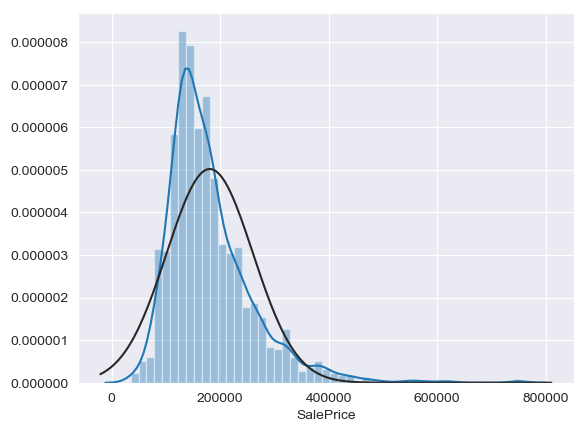

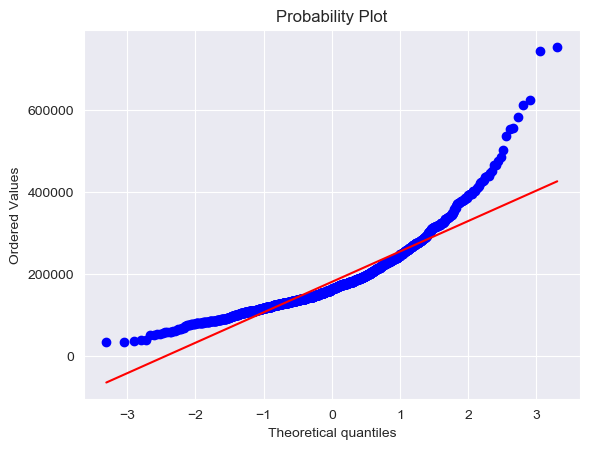

In [25]:
sns.distplot(training_data['SalePrice'],fit=norm)
fig = plt.figure()
res = stats.probplot(training_data['SalePrice'], plot=plt)

On Visual inspection, we can see that Sale Price does not have a perfectly normal distribution. It is skewed to the right. We can confirm this further with a Q-Q plot.

In [26]:
skew(training_data['SalePrice'])

1.8778593479363705

Try log transformation:

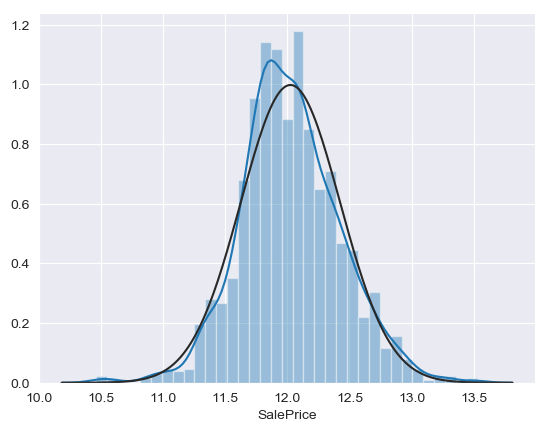

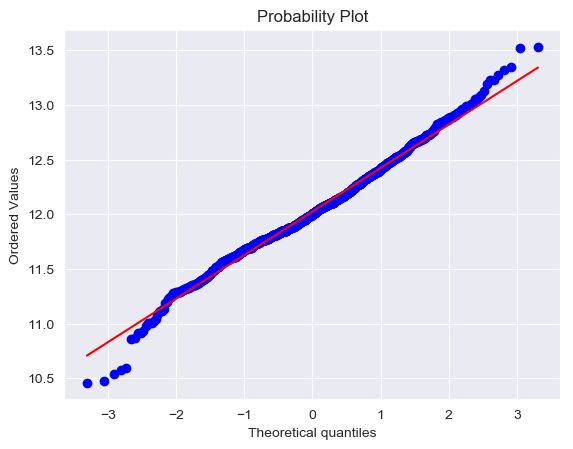

In [27]:
sns.distplot(np.log(training_data['SalePrice']),fit=norm)
fig = plt.figure()
res = stats.probplot(np.log(training_data['SalePrice']), plot=plt)

The result is a more normal distribution. We will use the common rule of thumb and apply this transformation to all features with greater than 0.5 skew. Many of them contain zero, so we must use log1p = log(x + 1)

In [28]:
training_data['SalePrice']=np.log(training_data['SalePrice'])

In [29]:
num_features=test_data.select_dtypes(exclude=object).columns
num_features

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [30]:
skewed=[]
for col in num_features:
    if abs(skew(data[col]))>0.5:
        data[col]=np.log1p(data[col])
        skewed.append(col)
skewed

['LotArea',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal']

# Culling categories with very few data points

Looking for categories with very few data points (i.e. Roof Matl==ClayShingle, which is only one house). These have no useful predictive ability and just proliferate unnecessary features when we do onehot transformation.

In [31]:
cat_features=training_data.select_dtypes(include=object).columns
cat_features

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical', 'GarageType',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [32]:
list(training_data['RoofMatl'].value_counts()[training_data['RoofMatl'].value_counts()==1].index)

['Membran', 'Metal', 'Roll', 'ClyTile']

In [33]:
unique_cats=[]
unqcats=[]
for col in cat_features:
    unqs=list(training_data[col].value_counts()[training_data[col].value_counts()<=5].index)
    for i in range(len(unqs)):
        unqs[i]=col + '_' + unqs[i]
    if len(unqs)>0:
        unqcats.append(unqs)
for sublist in unqcats:
    for item in sublist:
        unique_cats.append(item)
unique_cats

['MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES',
 'Utilities_NoSeWa',
 'LotConfig_FR3',
 'Neighborhood_Blueste',
 'Condition1_RRNn',
 'Condition1_RRNe',
 'Condition2_RRNn',
 'Condition2_PosN',
 'Condition2_Artery',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_PosA',
 'RoofStyle_Shed',
 'RoofMatl_WdShake',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_ClyTile',
 'Exterior1st_Stone',
 'Exterior1st_BrkComm',
 'Exterior1st_AsphShn',
 'Exterior1st_ImStucc',
 'Exterior1st_CBlock',
 'Exterior2nd_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Other',
 'Exterior2nd_CBlock',
 'Foundation_Wood',
 'Heating_Wall',
 'Heating_OthW',
 'Heating_Floor',
 'Electrical_FuseP',
 'Electrical_Mix',
 'MiscFeature_Othr',
 'MiscFeature_Gar2',
 'MiscFeature_TenC',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_CWD',
 'SaleType_Oth',
 'SaleType_Con',
 'SaleCondition_AdjLand']

In [34]:
len(unique_cats)

42

# Normalization of numerical features

In [35]:
for col in num_features:
    data[col]=(data[col]-data[col].mean())/data[col].std()

# One-hot / get dummies transformation

In [36]:
onehot_data=pd.get_dummies(data)
onehot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 1 to 2919
Columns: 257 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(51), uint8(206)
memory usage: 1.7 MB


# Removing Low-count categorical dummy features

In [37]:
onehot_data.drop(columns=unique_cats,inplace=True)

Re-split into training and test

In [38]:
X_test=onehot_data.iloc[1457:]
X=onehot_data.iloc[:1457]
y=training_data['SalePrice']

In [39]:
pd.options.display.max_seq_items = 300

# Remove features with no correlation with sale price (Doing this actually made results worse. Will suppress for now)

In [40]:
uncorrelated=X.join(y).corr()['SalePrice'][(np.abs(X.join(y).corr()['SalePrice'])<0.05)]
uncorrelated.index

Index(['OverallCond', 'BsmtFinSF2', 'BsmtHalfBath', 'YrSold',
       'MSSubClass_2-1/2 STORY ALL AGES', 'MSSubClass_2-STORY 1945 & OLDER',
       'MSSubClass_SPLIT FOYER', 'MSSubClass_SPLIT OR MULTI-LEVEL',
       'Alley_Pave', 'LotShape_IR3', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_FR2',
       'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blmngtn', 'Neighborhood_Mitchel', 'Neighborhood_NPkVill',
       'Neighborhood_SawyerW', 'Condition1_RRAe', 'Condition1_RRAn',
       'Condition2_Norm', 'BldgType_TwnhsE', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_SLvl', 'RoofStyle_Flat',
       'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofMatl_Tar&Grv',
       'Exterior1st_BrkFace', 'Exterior1st_Plywood', 'Exterior1st_Stucco',
       'Exterior2nd_BrkFace', 'Exterior2nd_ImStucc', 'Exterior2nd_Plywood',
       'MasVnrType_BrkCmn', 'Foundation_Stone', 'BsmtFinType2_ALQ',
       'BsmtFinType2_GLQ', 'B

In [41]:
#X.drop(columns=uncorrelated.index,inplace=True)
#X_test.drop(columns=uncorrelated.index,inplace=True)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 1 to 1460
Columns: 215 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(51), uint8(164)
memory usage: 865.3 KB


In [43]:
y.describe()

count    1457.000000
mean       12.024200
std         0.399835
min        10.460242
25%        11.774520
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

# Training the Linear Regression

# Lasso Regression

I choose Lasso Regression because the L1 regularization parameter tends to narrow down to 0 many of the irrelevant features. Too many features are prone to a high variance overfitting regime.
Lasso minimizes the equation:

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

where w is the coefficients vector and alpha the regularization parameter.

To find alpha: First search in logspace, than a more fine grain search in linear space.

In [44]:
alphas = np.logspace(-4,3,15)
#alphas = np.linspace(3e-4,7e-4,41)
alphas

array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

In [45]:
lasso=LassoCV(cv=5,alphas=alphas).fit(X,y)
print('Converged to an alpha of '+str(lasso.alpha_)+'.')
print('Lasso has reduced the original features to ' + str(sum(lasso.coef_!=0)) + 
      ' features out of ' + str(len(lasso.coef_)))
y_pred=lasso.predict(X)
print('R Score (training data): '+str(lasso.score(X,y)))
print('RMSE of the log (training data): ' + str(np.sqrt(metrics.mean_squared_error(y,
                        y_pred))))

Converged to an alpha of 0.001.
Lasso has reduced the original features to 79 features out of 215
R Score (training data): 0.9163017280799058
RMSE of the log (training data): 0.1156351776616339


In [46]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Plot learning curve

In [47]:
from sklearn.model_selection import learning_curve

In [48]:
#def RMSE(y,y_pred):
#    err=np.sqrt(metrics.mean_squared_error(y,y_pred))
#    return err

In [49]:
def RMSE(y,y_pred):
    err=np.sqrt(metrics.mean_squared_error(y,y_pred))
    return err

In [50]:
def RMSE_forscoring(estimator,X,y):
    y_pred=estimator.predict(X)
    err=np.sqrt(metrics.mean_squared_error(y,
                        y_pred))
    return err

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

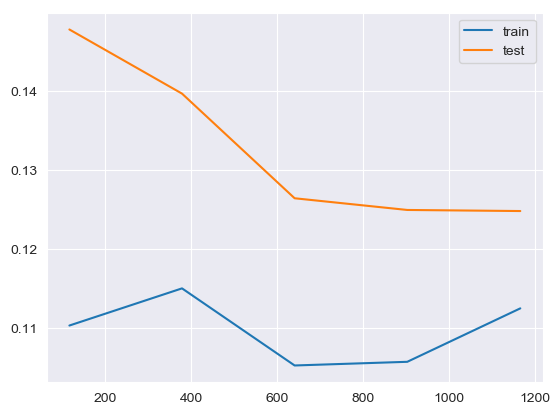

In [51]:
iter, train_scores, crossval_scores = learning_curve(lasso,X,y,cv=5,scoring=RMSE_forscoring)

train_scores_mean=train_scores.mean(axis=1)
crossval_scores_mean=crossval_scores.mean(axis=1)

sns.lineplot(x=iter,y=train_scores_mean)
sns.lineplot(x=iter,y=crossval_scores_mean)
plt.legend(['train','test'])

In [52]:
print('RMSE of the log (cross validation data): ' + str(crossval_scores_mean[-1]))

RMSE of the log (cross validation data): 0.12478678619767765


This learning curve is instructive. It is a classic learning curve indicative of high variance. The final error on the training data is very good, but the error on the test data is much higher. We can not get more samples, and the regularization parameters are already optimized.
Therefore we must decrease the number of features. Indeed many of them have little correlation with SalePrice.

After this point, I tried several other algorithms, and all of them show a similar high variance learning curve. My next step (not in this notebook sequence but next on my to do list) will be to go back, delete unnecessary features and consolidate features with high mutual correlation.

RMSE of the log (test, from kaggle): 0.12238

Looking at the resulting Coefficients:

In [53]:
cdf = pd.DataFrame(lasso.coef_,X.columns,columns=['Coeff'])
cdf.sort_values('Coeff',ascending=False)

,Coeff
GrLivArea,0.123979
Neighborhood_Crawfor,0.084193
OverallQual,0.081074
Neighborhood_NridgHt,0.077657
Neighborhood_StoneBr,0.074338
Neighborhood_NoRidge,0.058749
Condition1_Norm,0.051169
Exterior1st_BrkFace,0.049280
LotArea,0.041874
OverallCond,0.041676


In [54]:
final_answers=lasso.predict(X_test)
sub = pd.DataFrame({'Id':X_test.index,'SalePrice':final_answers})
sub.set_index('Id',inplace=True)
sub=np.exp(sub)
sub.head()

,SalePrice
Id,
1461,115388.669027
1462,156229.052721
1463,179224.759402
1464,197804.223810
1465,200706.750702


In [55]:
#sub.to_csv('submission10.csv')

# Elastic Net

Elastic net is a linear combination of Ridge (L2) regression and Lasso(L1) Regression, which optimizes the equation

1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

with respect to alpha and the l1 ratio.

In [56]:
from sklearn.linear_model import ElasticNetCV

In [57]:
alphas = np.logspace(-4,3,15)
#l1_ratio=[.1, .5, .7, .9, .95, .99, 1]
l1_ratio=np.linspace(.55,.85,7)
elastic=ElasticNetCV(cv=5,alphas=alphas,l1_ratio=l1_ratio).fit(X,y)

In [58]:
print('Converged to an alpha of '+str(elastic.alpha_)+'.')
print('Converged to an l1 ratio of '+str(elastic.l1_ratio_)+'.')
print('Lasso has reduced the original features to ' + str(sum(elastic.coef_!=0)) + 
      ' features out of ' + str(len(elastic.coef_)))
y_pred=elastic.predict(X)
print('R Score (training data): '+str(elastic.score(X,y)))
print('RMSE of the log (training data): ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

Converged to an alpha of 0.001.
Converged to an l1 ratio of 0.65.
Lasso has reduced the original features to 96 features out of 215
R Score (training data): 0.9201184478979986
RMSE of the log (training data): 0.11296787867446159


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

Text(0.5, 1.0, 'Elastic Net Learning Curve')

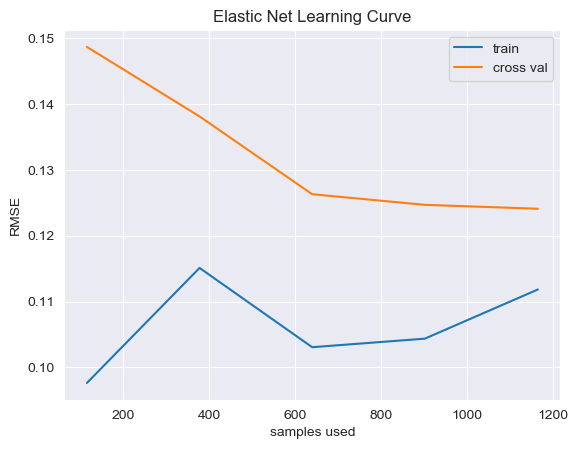

In [59]:
iter, train_scores, crossval_scores = learning_curve(elastic,X,y,cv=5,scoring=RMSE_forscoring)

train_scores_mean=train_scores.mean(axis=1)
crossval_scores_mean=crossval_scores.mean(axis=1)

sns.lineplot(x=iter,y=train_scores_mean)
sns.lineplot(x=iter,y=crossval_scores_mean)
plt.legend(['train','cross val'])
plt.xlabel('samples used')
plt.ylabel('RMSE')
plt.title('Elastic Net Learning Curve')

In [60]:
print('RMSE of the log (cross validation data): ' + str(crossval_scores_mean[-1]))

RMSE of the log (cross validation data): 0.12408361023317582


RMSE of the log (test data): 0.12231 (from kaggle)

# Bayesian Ridge Regression

In [61]:
from sklearn.linear_model import BayesianRidge

In [62]:
bayes=BayesianRidge().fit(X,y)

In [63]:
print('Estimated precision of noise: '+str(bayes.alpha_)+'.')
print('Estimated precision of weights '+str(bayes.lambda_)+'.')
y_pred=bayes.predict(X)
print('R Score: '+str(bayes.score(X,y)))
print('RMSE of the log: ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

Estimated precision of noise: 76.0600586228532.
Estimated precision of weights 984.35126111533.
R Score: 0.9251395711246237
RMSE of the log: 0.10935984391339101


RMSE of the log (test data): 0.12323

Text(0.5, 1.0, 'Bayesian Ridge Learning Curve')

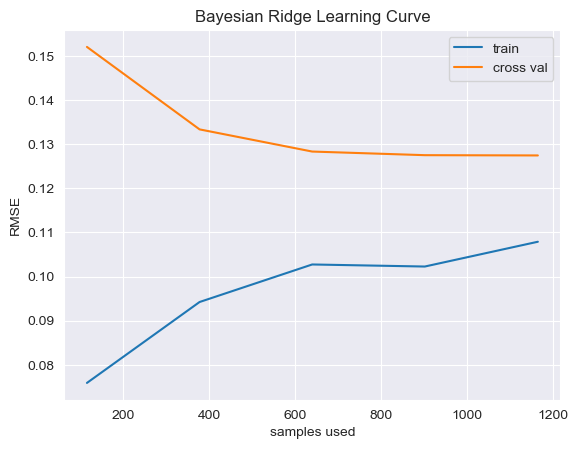

In [64]:
iter, train_scores, crossval_scores = learning_curve(bayes,X,y,cv=5,scoring=RMSE_forscoring)

train_scores_mean=train_scores.mean(axis=1)
crossval_scores_mean=crossval_scores.mean(axis=1)

sns.lineplot(x=iter,y=train_scores_mean)
sns.lineplot(x=iter,y=crossval_scores_mean)
plt.legend(['train','cross val'])
plt.xlabel('samples used')
plt.ylabel('RMSE')
plt.title('Bayesian Ridge Learning Curve')

In [65]:
print('RMSE of the log (cross validation data): ' + str(crossval_scores_mean[-1]))

RMSE of the log (cross validation data): 0.12744373951170446


RMSE of the log (test data): 0.12323

# Automatic Relevance Determination

In [66]:
from sklearn.linear_model import ARDRegression

In [67]:
ARD = ARDRegression().fit(X,y)

In [68]:
print('Estimated precision of noise: '+str(ARD.alpha_)+'.')
print('Estimated precision of weights '+str(ARD.lambda_)+'.')
y_pred=ARD.predict(X)
print('R Score: '+str(ARD.score(X,y)))
print('RMSE of the log: ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

Estimated precision of noise: 80.85360734269057.
Estimated precision of weights [1.61336958e+04 7.24690792e+02 2.09527704e+02 5.29794729e+02
 6.83952562e+02 6.93989979e+03 2.54670443e+05 2.25566482e+05
 4.19211838e+05 2.48290383e+03 4.12704252e+04 3.85589383e+03
 6.53532207e+02 3.23534688e+04 1.31499659e+04 1.57087343e+02
 5.36694312e+03 7.93229415e+03 1.00608440e+04 4.58696148e+05
 4.36412773e+04 5.00907615e+01 3.49386179e+03 1.25751883e+05
 5.45926982e+03 4.96996797e+03 4.22111925e+04 3.92670157e+03
 3.27610683e+03 2.05057731e+04 2.49142092e+03 1.86275736e+04
 1.40648179e+04 3.00173862e+05 1.75962512e+04 5.28552906e+02
 1.07989564e+05 7.32268934e+02 1.41078234e+04 2.75041900e+04
 1.42857590e+04 4.99834830e+04 4.10133701e+04 5.08443196e+04
 5.62533900e+03 7.45982964e+04 4.78149839e+04 4.52049740e+05
 3.44981514e+04 6.49864153e+04 3.91657419e+04 1.83391649e+04
 1.76596526e+04 1.00000000e+00 8.01434713e+04 2.55032617e+03
 4.61806087e+04 2.45739838e+04 1.46977436e+04 1.01415176e+04
 6.09

Text(0.5, 1.0, 'ARD Learning Curve')

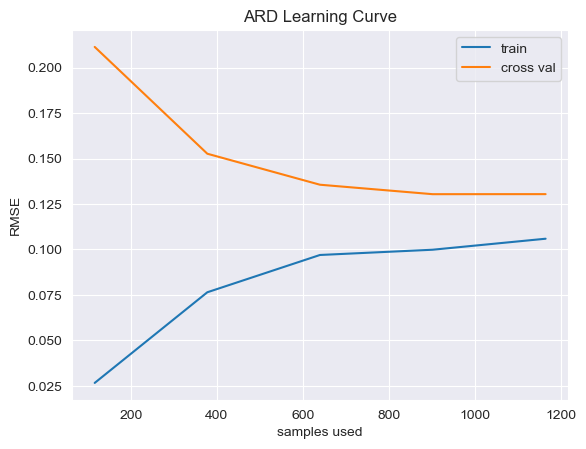

In [69]:
iter, train_scores, crossval_scores = learning_curve(ARD,X,y,cv=5,scoring=RMSE_forscoring)

train_scores_mean=train_scores.mean(axis=1)
crossval_scores_mean=crossval_scores.mean(axis=1)

sns.lineplot(x=iter,y=train_scores_mean)
sns.lineplot(x=iter,y=crossval_scores_mean)
plt.legend(['train','cross val'])
plt.xlabel('samples used')
plt.ylabel('RMSE')
plt.title('ARD Learning Curve')

In [70]:
print('RMSE of the log (cross validation data): ' + str(crossval_scores_mean[-1]))

RMSE of the log (cross validation data): 0.1304435356695839


In [71]:
final_answers=ARD.predict(X_test)
sub = pd.DataFrame({'Id':X_test.index,'SalePrice':final_answers})
sub.set_index('Id',inplace=True)
sub=np.exp(sub)
sub.head()

,SalePrice
Id,
1461,116720.787128
1462,160128.189428
1463,180463.549973
1464,195118.111988
1465,217776.930787


In [72]:
#sub.to_csv('submission5.csv')

RMSE of the log (test data), from Kaggle: 0.12940
The training error went down while the test error went up. overfitting perhaps.

# Gradient Boosting

In [73]:
from sklearn import ensemble

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

In [75]:
GBR = GradientBoostingRegressor(loss='huber').fit(X,y)

In [76]:
y_pred=GBR.predict(X)
print('RMSE of the log: ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

RMSE of the log: 0.08774203256147577


In [77]:
final_answers=GBR.predict(X_test)
sub = pd.DataFrame({'Id':X_test.index,'SalePrice':final_answers})
sub.set_index('Id',inplace=True)
sub=np.exp(sub)
sub.head()

,SalePrice
Id,
1461,121563.696500
1462,164151.095581
1463,181098.854855
1464,186119.309407
1465,194112.259448


In [78]:
#sub.to_csv('submission7.csv')

RMSE of the log (test data, from kaggle): 0.13454
An even more marked split between training and test error. Need to further tinker with this algorithm to address overfitting.

Text(0.5, 1.0, 'Gradient Boosting Learning Curve')

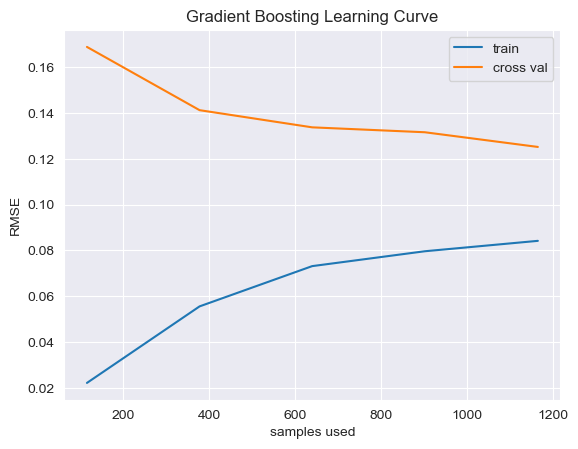

In [79]:
iter, train_scores, crossval_scores = learning_curve(GBR,X,y,cv=5,scoring=RMSE_forscoring)

train_scores_mean=train_scores.mean(axis=1)
crossval_scores_mean=crossval_scores.mean(axis=1)

sns.lineplot(x=iter,y=train_scores_mean)
sns.lineplot(x=iter,y=crossval_scores_mean)
plt.legend(['train','cross val'])
plt.xlabel('samples used')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Learning Curve')

In [80]:
print('RMSE of the log (cross validation data): ' + str(crossval_scores_mean[-1]))

RMSE of the log (cross validation data): 0.12513921939471653


# Revisiting Lasso Regression.

So far Lasso regression has had the best results. Going back to that section, I noticed that the the LassoCV function optimizes by the R-score, and this is hard-coded in. But the metric of importance is the root mean square error of the log (RMSE), and because it does not linearly map to R-score, the final algorithm is slightly different when optimized by RMSE. To be thorough, I will return to Lasso regression and use the GridSearchCV function to customize the scoring of the cross validation.

In [81]:
#def RMSEscorer(estimator,X,y):
#    okdnfao=make_scorer(score_func=RMSE_forscoring,greater_is_better=False)
#    return okdnfao

RMSEscorer=make_scorer(score_func=RMSE,greater_is_better=False)

In [82]:
#alphas = np.logspace(-4,3,15)
alphas = np.linspace(3e-4,4e-3,11)
alphas

array([0.0003 , 0.00067, 0.00104, 0.00141, 0.00178, 0.00215, 0.00252,
       0.00289, 0.00326, 0.00363, 0.004  ])

In [83]:
lasso2=GridSearchCV(cv=5,estimator=Lasso(),param_grid={'alpha':alphas},
                    scoring=RMSEscorer,n_jobs=-1)
lasso2.fit(X,y)

results=pd.DataFrame(lasso2.cv_results_)
results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.094548,0.013025,0.001995,0.001545,0.0003,{'alpha': 0.0003},-0.110495,-0.130520,-0.124854,-0.112533,...,-0.125136,0.013368,3,-0.109512,-0.104263,-0.106060,-0.108197,-0.101809,-0.105968,0.002748
1,0.060640,0.009720,0.001993,0.000006,0.00067,{'alpha': 0.00067},-0.108466,-0.131203,-0.122364,-0.110683,...,-0.123989,0.014239,1,-0.114296,-0.109454,-0.111296,-0.113619,-0.105941,-0.110921,0.003025
2,0.039694,0.010729,0.007181,0.007839,0.00104,{'alpha': 0.00104},-0.107616,-0.133455,-0.123300,-0.110831,...,-0.124636,0.014870,2,-0.117931,-0.112968,-0.114447,-0.117143,-0.109106,-0.114319,0.003164
3,0.047273,0.011117,0.001796,0.000397,0.00141,{'alpha': 0.0014099999999999998},-0.108713,-0.136187,-0.125110,-0.112202,...,-0.126252,0.015005,4,-0.121092,-0.116029,-0.117773,-0.119872,-0.112079,-0.117369,0.003165
4,0.045155,0.019340,0.001595,0.000488,0.00178,{'alpha': 0.00178},-0.111358,-0.139203,-0.127132,-0.114271,...,-0.128466,0.014777,5,-0.124193,-0.119131,-0.120833,-0.122931,-0.115091,-0.120436,0.003187
5,0.037322,0.013428,0.001597,0.000489,0.00215,{'alpha': 0.00215},-0.113152,-0.140448,-0.128462,-0.116592,...,-0.130099,0.014512,6,-0.126575,-0.121062,-0.123226,-0.126048,-0.118147,-0.123012,0.003144
6,0.039595,0.012856,0.001796,0.001164,0.00252,{'alpha': 0.0025199999999999997},-0.114066,-0.140970,-0.129346,-0.117458,...,-0.130975,0.014552,7,-0.128093,-0.122140,-0.124843,-0.127497,-0.120295,-0.124573,0.003008
7,0.028926,0.002089,0.001400,0.000486,0.00289,{'alpha': 0.0028899999999999998},-0.114932,-0.141538,-0.130012,-0.118309,...,-0.131710,0.014475,8,-0.129268,-0.123178,-0.125848,-0.128619,-0.121388,-0.125660,0.003040
8,0.036104,0.004983,0.002594,0.001619,0.00326,{'alpha': 0.00326},-0.115847,-0.142067,-0.130678,-0.119232,...,-0.132343,0.014188,9,-0.130345,-0.124063,-0.126923,-0.129733,-0.122100,-0.126633,0.003182
9,0.030918,0.007383,0.001196,0.000399,0.00363,{'alpha': 0.00363},-0.116511,-0.142705,-0.131339,-0.119898,...,-0.132864,0.013977,10,-0.131284,-0.124991,-0.128016,-0.130684,-0.122739,-0.127543,0.003276


In [84]:
print('Converged to an alpha of '+str(lasso2.best_params_['alpha'])+'.')
print('Lasso has reduced the original features to ' + str(sum(lasso2.best_estimator_.coef_!=0)) + 
      ' features out of ' + str(len(lasso2.best_estimator_.coef_)))
y_pred=lasso2.best_estimator_.predict(X)
print('R Score (training data): '+str(lasso2.best_estimator_.score(X,y)))
print('RMSE of the log (training data): ' + 
      str(-(results[results['rank_test_score']==1]['mean_train_score'].values[0])))
print('RMSE of the log(cross validation): ' + str(-lasso2.best_score_))
#print('RMSE of the log (training data): ' + str(np.sqrt(metrics.mean_squared_error(y,
#                        y_pred))))

Converged to an alpha of 0.00067.
Lasso has reduced the original features to 93 features out of 215
R Score (training data): 0.9201062780171942
RMSE of the log (training data): 0.11092126994978362
RMSE of the log(cross validation): 0.12398906675634307


Text(0.5, 1.0, 'Learning Curve (Lasso with GridSearchCV)')

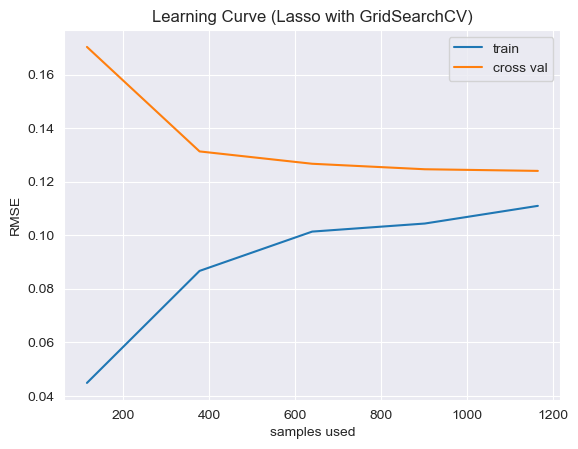

In [85]:
iter, train_scores, crossval_scores = learning_curve(lasso2.best_estimator_,X,y,cv=5,scoring=RMSE_forscoring)

train_scores_mean=train_scores.mean(axis=1)
crossval_scores_mean=crossval_scores.mean(axis=1)

sns.lineplot(x=iter,y=train_scores_mean)
sns.lineplot(x=iter,y=crossval_scores_mean)
plt.legend(['train','cross val'])
plt.xlabel('samples used')
plt.ylabel('RMSE')
plt.title('Learning Curve (Lasso with GridSearchCV)')

In [86]:
final_answers=lasso2.best_estimator_.predict(X_test)
sub = pd.DataFrame({'Id':X_test.index,'SalePrice':final_answers})
sub.set_index('Id',inplace=True)
sub=np.exp(sub)
sub.head()

,SalePrice
Id,
1461,114844.763751
1462,156177.820390
1463,178719.015899
1464,196477.558857
1465,204591.429132


In [87]:
sub.to_csv('submission14.csv')

Upon submission to Kaggle, the RMSE of the test data is 0.11996
This puts me in Leaderboard position 927/3984, and in the top 24% of results.

# Taking a look at the coefficients in our model

In [88]:
cdf = pd.DataFrame(lasso2.best_estimator_.coef_,X.columns,columns=['Coeff'])

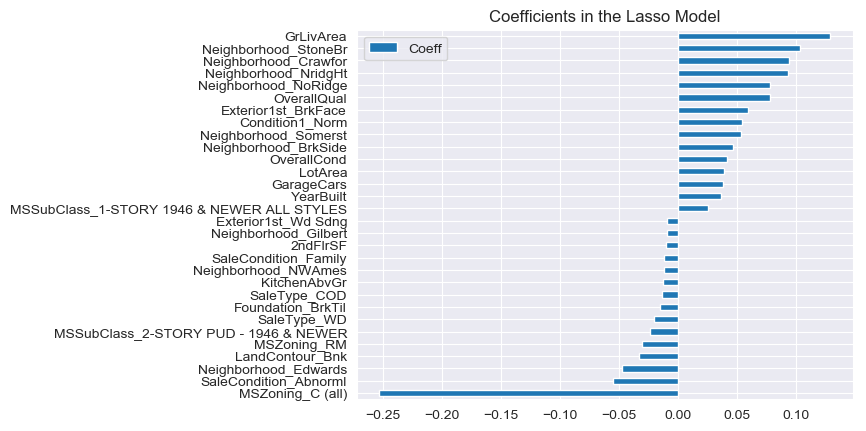

In [89]:
imp_coefs = pd.concat([cdf.sort_values('Coeff').head(15),
                     cdf.sort_values('Coeff').tail(15)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

The top positive predictors of Sale Price are:
Above Ground Living Area
Overall Quality
Overall Condition
Lot Area
Year Built (Newer is better)
Car Capacity of Garage

Some of the most prominent predictors are certain neighborhoods such as:
Stone Bridge
Crawford
Northridge Heights



Other features that indictate high real estate values:
brick face exterior
wood shingle roof
newly built house


On the other hand, factors that tend to drive down sale price:
Abnormal Sale Condition
Banked land contour
2-story Planned Unit Development
Neighborhoods: Edwards, Iowa DOT and Railroad

# Plotting Sale Price against predicted value

Text(0.5, 1.0, 'Log of the Sale Price (Real vs. Predicted)')

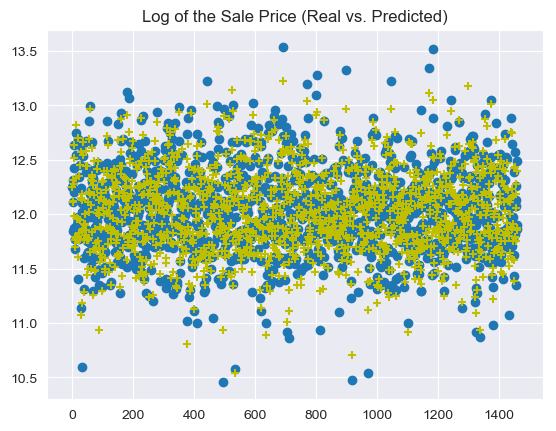

In [90]:
plt.scatter(y.index.values,y)
plt.scatter(y.index.values,y_pred,c='y',marker='+')
plt.title('Log of the Sale Price (Real vs. Predicted)')